In [10]:
import gc
import itertools
from functools import partial
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.semi_supervised import LabelPropagation
import sklearn.multioutput
from tqdm.notebook import tqdm
# import lightning.torch


from retrain_bert.data import MixedDatasetModule, load_labels, load_train_data
from retrain_bert.model import AlgoriAecocCategorization
from retrain_bert import settings
from retrain_bert import metrics
from retrain_bert.preprocessor import get_labels_conf
from retrain_bert.utils import (ExactCategoryScore, make_targets)


In [2]:
labels = load_labels()
labels_conf = get_labels_conf(labels)
data = load_train_data()


In [3]:
data = MixedDatasetModule(
    train_data=data["train"],
    val_data=data["validation"],
    test_data=data["unseen_categories"],
    labels_conf=labels_conf,
)
data.setup()

In [4]:
model = AlgoriAecocCategorization.load_from_checkpoint(
    '/home/julius/lp/algori/retrain_bert/models/epoch=9-val_loss=4.42.ckpt',
    labels_conf=labels_conf,
)

In [17]:
unseen_preds = []
unseen_targets = []
for batch in tqdm(data.test_dataloader()):
    attention_mask, input_ids, targets = batch
    attention_mask = attention_mask.cuda()
    input_ids = input_ids.cuda()
    # print(attention_mask[0].device, input_ids, targets)
    preds = model(attention_mask, input_ids)
    preds = [p.cpu().detach() for p in preds]
    unseen_preds.append(preds)
    targets = [t.cpu().detach() for t in targets]
    unseen_targets.append(targets)

  0%|          | 0/1549 [00:00<?, ?it/s]

In [27]:
results = []
for preds, targets in zip(unseen_preds, unseen_targets):
    level1_pred = preds[0].argmax(dim=1)
    level1_target = targets[0].argmax(dim=1)
    accuracy = metrics.cumulative_accuracy(preds, targets)
    df = pd.DataFrame({"level1_pred": level1_pred.numpy(), "level1_target": level1_target.numpy()})
    for i in range(len(accuracy)):
        df[f"level{i+1}_accuracy"] = accuracy[i]
    results.append(df)
results = pd.concat(results, ignore_index=True)

<Axes: xlabel='level1_target', ylabel='level1_accuracy'>

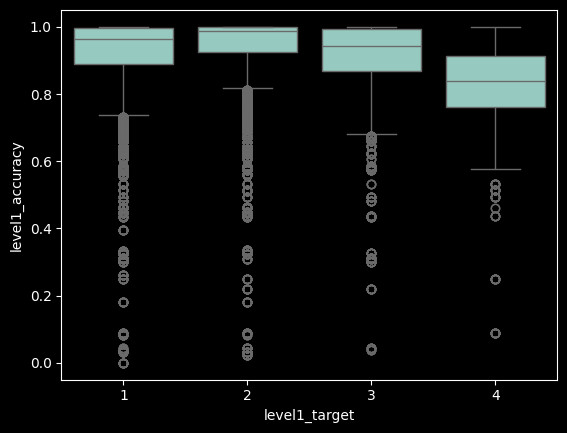

In [37]:
sns.boxplot(data=results, x='level1_target', y='level1_accuracy')
# plt.suptitle("Accurac")